In [1]:
# # Code to convert this notebook to .py if you want to run it via command line or with Slurm
# from subprocess import call
# command = "jupyter nbconvert Train.ipynb --to python"
# call(command,shell=True)

# Import packages & functions

In [2]:
import os
import sys
import json
import argparse
import numpy as np
import math
from einops import rearrange
import time
import random
import h5py
from tqdm import tqdm

import webdataset as wds
import gc

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms

from accelerate import Accelerator, DeepSpeedPlugin

# tf32 data type is faster than standard float32
torch.backends.cuda.matmul.allow_tf32 = True

# custom functions #
import utils

global_batch_size = 128 #128

In [3]:
### Multi-GPU config ###
local_rank = os.getenv('RANK')
if local_rank is None: 
    local_rank = 0
else:
    local_rank = int(local_rank)
print("LOCAL RANK ", local_rank)  

num_devices = torch.cuda.device_count()
if num_devices==0: num_devices = 1

accelerator = Accelerator(split_batches=False)

### UNCOMMENT BELOW STUFF TO USE DEEPSPEED (also comment out the immediately above "accelerator = " line) ###

# if num_devices <= 1 and utils.is_interactive():
#     # can emulate a distributed environment for deepspeed to work in jupyter notebook
#     os.environ["MASTER_ADDR"] = "localhost"
#     os.environ["MASTER_PORT"] = str(np.random.randint(10000)+9000)
#     os.environ["RANK"] = "0"
#     os.environ["LOCAL_RANK"] = "0"
#     os.environ["WORLD_SIZE"] = "1"
#     os.environ["GLOBAL_BATCH_SIZE"] = str(global_batch_size) # set this to your batch size!
#     global_batch_size = os.environ["GLOBAL_BATCH_SIZE"]

# # alter the deepspeed config according to your global and local batch size
# if local_rank == 0:
#     with open('deepspeed_config_stage2.json', 'r') as file:
#         config = json.load(file)
#     config['train_batch_size'] = int(os.environ["GLOBAL_BATCH_SIZE"])
#     config['train_micro_batch_size_per_gpu'] = int(os.environ["GLOBAL_BATCH_SIZE"]) // num_devices
#     with open('deepspeed_config_stage2.json', 'w') as file:
#         json.dump(config, file)
# else:
#     # give some time for the local_rank=0 gpu to prep new deepspeed config file
#     time.sleep(10)
# deepspeed_plugin = DeepSpeedPlugin("deepspeed_config_stage2.json")
# accelerator = Accelerator(split_batches=False, deepspeed_plugin=deepspeed_plugin)

LOCAL RANK  0


In [4]:
print("PID of this process =",os.getpid())
device = accelerator.device
print("device:",device)
num_workers = num_devices
print(accelerator.state)
world_size = accelerator.state.num_processes
distributed = not accelerator.state.distributed_type == 'NO'
print("distributed =",distributed, "num_devices =", num_devices, "local rank =", local_rank, "world size =", world_size)
print = accelerator.print # only print if local_rank=0

PID of this process = 4027402
device: cuda
Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: no

distributed = False num_devices = 1 local rank = 0 world size = 1


# Configurations

In [5]:
# if running this interactively, can specify jupyter_args here for argparser to use
if utils.is_interactive():
    # Example use
    jupyter_args = f"--data_path=/fsx/proj-fmri/shared/mindeyev2_dataset \
                    --model_name=test \
                    --subj=1 --batch_size={global_batch_size} --n_samples_save=0 \
                    --max_lr=3e-4 --mixup_pct=.66 --num_epochs=120 --ckpt_interval=999 --no-use_image_aug"

    jupyter_args = jupyter_args.split()
    print(jupyter_args)
    
    from IPython.display import clear_output # function to clear print outputs in cell
    %load_ext autoreload 
    # this allows you to change functions in models.py or utils.py and have this notebook automatically update with your revisions
    %autoreload 2 

['--data_path=/fsx/proj-fmri/shared/mindeyev2_dataset', '--model_name=test', '--subj=1', '--batch_size=128', '--n_samples_save=0', '--max_lr=3e-4', '--mixup_pct=.66', '--num_epochs=120', '--ckpt_interval=999', '--no-use_image_aug']


In [6]:
parser = argparse.ArgumentParser(description="Model Training Configuration")
parser.add_argument(
    "--model_name", type=str, default="testing",
    help="name of model, used for ckpt saving and wandb logging (if enabled)",
)
parser.add_argument(
    "--data_path", type=str, default="/fsx/proj-fmri/shared/natural-scenes-dataset",
    help="Path to where NSD data is stored / where to download it to",
)
parser.add_argument(
    "--subj",type=int, default=1, choices=[1,2,5,7],
)
parser.add_argument(
    "--batch_size", type=int, default=32,
    help="Batch size can be increased by 10x if only training v2c and not diffusion diffuser",
)
parser.add_argument(
    "--wandb_log",action=argparse.BooleanOptionalAction,default=False,
    help="whether to log to wandb",
)
parser.add_argument(
    "--resume_from_ckpt",action=argparse.BooleanOptionalAction,default=False,
    help="if not using wandb and want to resume from a ckpt",
)
parser.add_argument(
    "--wandb_project",type=str,default="stability",
    help="wandb project name",
)
parser.add_argument(
    "--mixup_pct",type=float,default=.33,
    help="proportion of way through training when to switch from BiMixCo to SoftCLIP",
)
parser.add_argument(
    "--use_image_aug",action=argparse.BooleanOptionalAction,default=True,
    help="whether to use image augmentation",
)
parser.add_argument(
    "--num_epochs",type=int,default=240,
    help="number of epochs of training",
)
parser.add_argument(
    "--lr_scheduler_type",type=str,default='cycle',choices=['cycle','linear'],
)
parser.add_argument(
    "--ckpt_saving",action=argparse.BooleanOptionalAction,default=True,
)
parser.add_argument(
    "--ckpt_interval",type=int,default=5,
    help="save backup ckpt and reconstruct every x epochs",
)
parser.add_argument(
    "--seed",type=int,default=42,
)
parser.add_argument(
    "--max_lr",type=float,default=3e-4,
)
parser.add_argument(
    "--n_samples_save",type=int,default=0,choices=[0,1],
    help="Number of reconstructions for monitoring progress, 0 will speed up training",
)

if utils.is_interactive():
    args = parser.parse_args(jupyter_args)
else:
    args = parser.parse_args()

# create global variables without the args prefix
for attribute_name in vars(args).keys():
    globals()[attribute_name] = getattr(args, attribute_name)

print("global batch_size", batch_size)
batch_size = int(batch_size / num_devices)
print("batch_size", batch_size)

global batch_size 128
batch_size 128


In [7]:
outdir = os.path.abspath(f'../train_logs/{model_name}')
if not os.path.exists(outdir):
    os.makedirs(outdir,exist_ok=True)
if use_image_aug:
    import kornia
    from kornia.augmentation.container import AugmentationSequential
    img_augment = AugmentationSequential(
        kornia.augmentation.RandomResizedCrop((224,224), (0.6,1), p=0.3),
        kornia.augmentation.Resize((224, 224)),
        kornia.augmentation.RandomHorizontalFlip(p=0.3),
        kornia.augmentation.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1, p=0.3),
        kornia.augmentation.RandomGrayscale(p=0.3),
        same_on_batch=False,
        data_keys=["input"],
    )

# Prep data, models, and dataloaders

## Dataloader

In [8]:
if subj==1:
    num_train = 24958
    num_test = 2770
test_batch_size = num_test

def my_split_by_node(urls): return urls
    
train_url = f"{data_path}/wds/subj0{subj}/train/" + "{0..36}.tar"
print(train_url)

train_data = wds.WebDataset(train_url,resampled=False,nodesplitter=my_split_by_node)\
                    .shuffle(750, initial=1500, rng=random.Random(42))\
                    .decode("torch")\
                    .rename(behav="behav.npy", past_behav="past_behav.npy", future_behav="future_behav.npy", olds_behav="olds_behav.npy")\
                    .to_tuple(*["behav", "past_behav", "future_behav", "olds_behav"])
train_dl = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True)

test_url = f"{data_path}/wds/subj0{subj}/test/" + "0.tar"
print(test_url)

test_data = wds.WebDataset(test_url,resampled=False,nodesplitter=my_split_by_node)\
                    .shuffle(750, initial=1500, rng=random.Random(42))\
                    .decode("torch")\
                    .rename(behav="behav.npy", past_behav="past_behav.npy", future_behav="future_behav.npy", olds_behav="olds_behav.npy")\
                    .to_tuple(*["behav", "past_behav", "future_behav", "olds_behav"])
test_dl = torch.utils.data.DataLoader(test_data, batch_size=test_batch_size, shuffle=False, drop_last=False, pin_memory=True)

/fsx/proj-fmri/shared/mindeyev2_dataset/wds/subj01/train/{0..36}.tar
/fsx/proj-fmri/shared/mindeyev2_dataset/wds/subj01/test/0.tar


## Load data and images

In [9]:
# load betas
f = h5py.File(f'{data_path}/betas_all_subj0{subj}.hdf5', 'r')
voxels = f['betas'][:]
print(f"subj0{subj} betas loaded into memory")
voxels = torch.Tensor(voxels).to("cpu").half()
if subj==1:
    voxels = torch.hstack((voxels, torch.zeros((len(voxels), 5))))
print("voxels", voxels.shape)
num_voxels = voxels.shape[-1]

# load orig images
f = h5py.File(f'{data_path}/coco_images_224_float16.hdf5', 'r')
images = f['images'][:]
images = torch.Tensor(images).to("cpu").half()
print("images", images.shape)

subj01 betas loaded into memory
voxels torch.Size([27750, 15729])
images torch.Size([73000, 3, 224, 224])


## Load models

### CLIP image embeddings  model

In [10]:
from models import Clipper
clip_model = Clipper("ViT-L/14", device=torch.device(f"cuda:{local_rank}"), hidden_state=True, norm_embs=True)

clip_seq_dim = 257
clip_emb_dim = 768
hidden_dim = 1280 #4096

ViT-L/14 cuda:0


### SD VAE (blurry images)

In [11]:
from diffusers import AutoencoderKL
autoenc = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16, cache_dir="/fsx/proj-fmri/shared/cache")
# autoenc.load_state_dict(torch.load('../train_logs/sdxl_vae_normed/best.pth')["model_state_dict"])
autoenc.eval()
autoenc.requires_grad_(False)
autoenc.to(device)
utils.count_params(autoenc)

param counts:
83,653,863 total
0 trainable


### MindEye modules

In [12]:
class MindEyeModule(nn.Module):
    def __init__(self):
        super(MindEyeModule, self).__init__()
    def forward(self, x):
        return x
        
model = MindEyeModule()
model

MindEyeModule()

In [13]:
class RidgeRegression(torch.nn.Module):
    # make sure to add weight_decay when initializing optimizer
    def __init__(self, input_size, out_features): 
        super(RidgeRegression, self).__init__()
        self.out_features = out_features
        self.linear = torch.nn.Linear(input_size, out_features)
    def forward(self, x):
        return self.linear(x)
        
model.ridge = RidgeRegression(voxels.shape[1], out_features=hidden_dim)
# model.past_ridge = RidgeRegression(voxels.shape[1], out_features=hidden_dim)
# model.future_ridge = RidgeRegression(voxels.shape[1], out_features=hidden_dim)
utils.count_params(model.ridge)
utils.count_params(model)

b = torch.randn((2,1,voxels.shape[1]))
print(b.shape, model.ridge(b).shape)

param counts:
20,134,400 total
20,134,400 trainable
param counts:
20,134,400 total
20,134,400 trainable
torch.Size([2, 1, 15729]) torch.Size([2, 1, 1280])


In [14]:
from functools import partial
class BrainNetwork(nn.Module):
    def __init__(self, out_dim=768, in_dim=15724, clip_size=768, h=4096, n_blocks=4, norm_type='ln', act_first=False, drop=.15, blurry_dim=16):
        super().__init__()
        self.blurry_dim = blurry_dim
        norm_func = partial(nn.BatchNorm1d, num_features=h) if norm_type == 'bn' else partial(nn.LayerNorm, normalized_shape=h)
        act_fn = partial(nn.ReLU, inplace=True) if norm_type == 'bn' else nn.GELU
        act_and_norm = (act_fn, norm_func) if act_first else (norm_func, act_fn)
        self.lin0 = nn.Linear(in_dim, h)
        self.mlp = nn.ModuleList([
            nn.Sequential(
                nn.Linear(h, h),
                *[item() for item in act_and_norm],
                nn.Dropout(drop)
            ) for _ in range(n_blocks)
        ])
        self.lin1 = nn.Linear(h, blurry_dim, bias=True)
        # self.blin1 = nn.Linear(h, blurry_dim, bias=True)
        self.n_blocks = n_blocks
        # self.clip_size = clip_size
        # self.clip_proj = nn.Sequential(
        #     nn.LayerNorm(clip_size),
        #     nn.GELU(),
        #     nn.Linear(clip_size, 2048),
        #     nn.LayerNorm(2048),
        #     nn.GELU(),
        #     nn.Linear(2048, 2048),
        #     nn.LayerNorm(2048),
        #     nn.GELU(),
        #     nn.Linear(2048, clip_size)
        # )
        self.blurry_proj = nn.Sequential(
                nn.LayerNorm(out_dim//8),
                nn.GELU(),
                nn.Linear(out_dim//8, blurry_dim),
                nn.LayerNorm(blurry_dim),
                nn.GELU(),
                nn.Linear(blurry_dim, blurry_dim),
                nn.LayerNorm(blurry_dim),
                nn.GELU(),
                nn.Linear(blurry_dim, blurry_dim)
            )
        
    def forward(self, x):
        x = self.lin0(x)
        residual = x
        for res_block in range(self.n_blocks):
            x = self.mlp[res_block](x)
            x += residual
            residual = x
        x = x.reshape(len(x), -1)
        x = self.lin1(x).reshape(len(x),4,-1)
        
        # b = self.blin1(x)
        # blur_out = [self.blurry_proj[l](b).unsqueeze(1) for l in range(patches_per_image)]
        # blur_out = torch.cat(blur_out, dim=1)
        # return self.clip_proj(c.reshape(len(c), -1, self.clip_size)), self.blurry_proj(c).view(len(c), 4, 28, 28)
        # b = self.blurry_proj(x) 
        
        return torch.zeros((1)), x

model.backbone = BrainNetwork(h=hidden_dim, in_dim=hidden_dim, clip_size=clip_emb_dim, out_dim=clip_emb_dim*clip_seq_dim, blurry_dim=4*hidden_dim) 
utils.count_params(model.backbone)
utils.count_params(model)

b = torch.randn((4,hidden_dim))
print(b.shape)
clip_, blur_ = model.backbone(b)
print(clip_.shape, blur_.shape)

param counts:
193,601,984 total
193,601,984 trainable
param counts:
213,736,384 total
213,736,384 trainable
torch.Size([4, 1280])
torch.Size([1]) torch.Size([4, 4, 1280])


### diffusion model

In [15]:
# from diffusers import StableDiffusionXLPipeline
# pipe = StableDiffusionXLPipeline.from_pretrained(
#     "/fsx/proj-fmri/shared/cache/models--stabilityai--stable-diffusion-xl-base-1.0/snapshots/f898a3e026e802f68796b95e9702464bac78d76f", torch_dtype=torch.float16, variant="fp16", use_safetensors=True
# )

from diffusers import DDIMScheduler
noise_scheduler = DDIMScheduler(
    num_train_timesteps=100,#pipe.scheduler.config.num_train_timesteps,
    beta_start=.00085,#pipe.scheduler.config.beta_start,
    beta_end=.012,#pipe.scheduler.config.beta_end,
    beta_schedule="scaled_linear",#pipe.scheduler.config.beta_schedule,
    trained_betas=None,#pipe.scheduler.config.trained_betas,
    clip_sample=False,#pipe.scheduler.config.clip_sample,
    set_alpha_to_one=False,#pipe.scheduler.config.set_alpha_to_one,
    steps_offset=1,#pipe.scheduler.config.steps_offset,
    prediction_type="epsilon",#pipe.scheduler.config.prediction_type
)

In [16]:
from diffusers import UNet2DConditionModel
unet = UNet2DConditionModel(
             in_channels=4,
             out_channels=4,
             norm_num_groups=32,
             cross_attention_dim=hidden_dim,
             attention_head_dim=8,
             block_out_channels=(hidden_dim//4, hidden_dim//4, hidden_dim//2, hidden_dim),
        )
unet.enable_xformers_memory_efficient_attention()
utils.count_params(unet)

param counts:
483,547,524 total
483,547,524 trainable


input torch.Size([8, 4, 28, 28])
encoder_hidden_states torch.Size([8, 4, 1280])
output latents torch.Size([4, 4, 28, 28])
output_image torch.Size([4, 3, 224, 224])


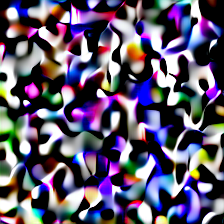

In [17]:
vae_scaling = .18215
num_inference_steps = 50
guidance_scale = 7.5
eta = 1

unet.to(device)
hidden_states = blur_.to(device)
bs = len(hidden_states)
# hidden_states = torch.randn(bs,unet.config.in_channels,hidden_dim).to(device)

@torch.no_grad()
def sd_sample(bs, unet, noise_scheduler, hidden_states, embedding_dim=28,
              guidance_scale=7.5, num_inference_steps=50, eta=1, device=device, verbose=False):
    with torch.no_grad():
        noise_scheduler.set_timesteps(num_inference_steps, device=device)
        latents = torch.randn(bs, unet.config.in_channels, embedding_dim, embedding_dim).to(device)
        
        for i, t in enumerate(noise_scheduler.timesteps):
            input = torch.cat([latents] * 2)
            encoder_hidden_states = torch.cat([torch.zeros_like(hidden_states), hidden_states])
            input = noise_scheduler.scale_model_input(input, t)
        
            # predict the noise residual
            if i==0 and verbose:
                print("input", input.shape)
                print("encoder_hidden_states", encoder_hidden_states.shape)
            pred = unet(input, t, encoder_hidden_states=encoder_hidden_states).sample
        
            # perform guidance
            pred_uncond, pred_text = pred.chunk(2)
            pred = pred_uncond + guidance_scale * (pred_text - pred_uncond)
        
            # compute the previous noisy sample
            scheduler_output = noise_scheduler.step(pred, t, latents, eta)
            latents = scheduler_output.prev_sample
        
        return latents

@torch.no_grad()
def decode_autoenc(latents,vae_scaling=vae_scaling):
    images = autoenc.decode(latents.half().cuda() / vae_scaling).sample
    images = images.clamp(0, 1).detach()
    return images

latents = sd_sample(bs, unet, noise_scheduler, hidden_states, embedding_dim=28, verbose=True)
print("output latents", latents.shape)
output_image = decode_autoenc(latents)
print("output_image", output_image.shape)
display(utils.torch_to_Image(output_image))

model.diffuser = unet; del unet

In [18]:
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
opt_grouped_parameters = [
    {'params': [p for n, p in model.ridge.named_parameters()], 'weight_decay': 1e-2},
    {'params': [p for n, p in model.backbone.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 1e-2},
    {'params': [p for n, p in model.backbone.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0},
    {'params': [p for n, p in model.diffuser.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 1e-2},
    {'params': [p for n, p in model.diffuser.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0},
]

optimizer = torch.optim.AdamW(opt_grouped_parameters, lr=max_lr, betas=(0.9, 0.999))

if lr_scheduler_type == 'linear':
    lr_scheduler = torch.optim.lr_scheduler.LinearLR(
        optimizer,
        total_iters=int(num_epochs*(num_train*num_devices//batch_size)),
        last_epoch=-1
    )
elif lr_scheduler_type == 'cycle':
    total_steps=int(num_epochs*(num_train*num_devices//batch_size))
    lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, 
        max_lr=max_lr,
        total_steps=total_steps,
        final_div_factor=1000,
        last_epoch=-1, pct_start=2/num_epochs
    )
    
def save_ckpt(tag):    
    ckpt_path = outdir+f'/{tag}.pth'
    print(f'saving {ckpt_path}',flush=True)
    unwrapped_model = accelerator.unwrap_model(model)
    try:
        torch.save({
            'epoch': epoch,
            'model_state_dict': unwrapped_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'lr_scheduler': lr_scheduler.state_dict(),
            'train_losses': losses,
            'test_losses': test_losses,
            'lrs': lrs,
            }, ckpt_path)
    except:
        print("Couldn't save... moving on to prevent crashing.")
    del unwrapped_model
        
print("\nDone with model preparations!")
utils.count_params(model)


Done with model preparations!
param counts:
697,283,908 total
697,283,908 trainable


# Weights and Biases

In [19]:
wandb_log = False

# Main

In [20]:
epoch = 0
losses, test_losses, lrs = [], [], []
best_test_loss = 1e9
soft_loss_temps = utils.cosine_anneal(0.004, 0.0075, num_epochs - int(mixup_pct * num_epochs))

# Optionally resume from checkpoint #
if resume_from_ckpt:
    print("\n---resuming from last.pth ckpt---\n")
    try:
        checkpoint = torch.load(outdir+'/last.pth', map_location='cpu')
    except:
        print('last.pth failed... trying last_backup.pth')
        checkpoint = torch.load(outdir+'/last_backup.pth', map_location='cpu')
    epoch = checkpoint['epoch']
    print("Epoch",epoch)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
    diffusion_diffuser.load_state_dict(checkpoint['model_state_dict'])
    del checkpoint
elif wandb_log:
    if wandb.run.resumed:
        print("\n---resuming from last.pth ckpt---\n")
        try:
            checkpoint = torch.load(outdir+'/last.pth', map_location='cpu')
        except:
            print('last.pth failed... trying last_backup.pth')
            checkpoint = torch.load(outdir+'/last_backup.pth', map_location='cpu')
        epoch = checkpoint['epoch']
        print("Epoch",epoch)
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
        diffusion_diffuser.load_state_dict(checkpoint['model_state_dict'])
        del checkpoint
torch.cuda.empty_cache()

In [21]:
model, optimizer, train_dl, test_dl, lr_scheduler = accelerator.prepare(
model, optimizer, train_dl, test_dl, lr_scheduler
)

test starting with epoch 0 / 120


  0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

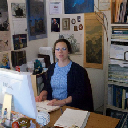

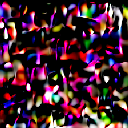

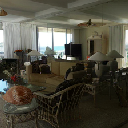

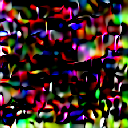

  1%|██████▊                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      | 1/120 [04:15<8:26:20, 255.30s/it, test/blurry_cossim=0, test/loss=4.74, test/loss_blurry_total=0, test/loss_clip_total=0, test/num_steps=1, test/test_bwd_pct_correct=0, test/test_f

---


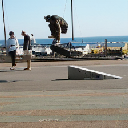

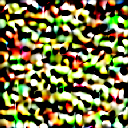

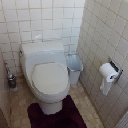

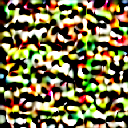

  2%|█████████████▌                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 | 2/120 [08:29<8:20:34, 254.53s/it, test/blurry_cossim=0, test/loss=12.6, test/loss_blurry_total=0, test/loss_clip_total=0, test/num_steps=2, test/test_bwd_pct_correct=0, test/test

---


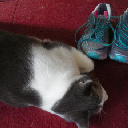

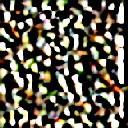

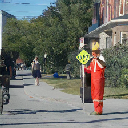

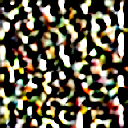

  2%|█████████████▌                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 | 2/120 [12:42<8:20:34, 254.53s/it, test/blurry_cossim=0, test/loss=19.6, test/loss_blurry_total=0, test/loss_clip_total=0, test/num_steps=3, test/test_bwd_pct_correct=0, test/test

---


  2%|████████████████████▍                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 3/120 [12:42<8:15:31, 254.11s/it, test/blurry_cossim=0, test/loss=19.6, test/loss_blurry_total=0, test/loss_clip_total=0, test/num_steps=3, test/test_bwd_pct_correct=0, test/test

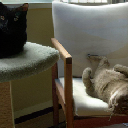

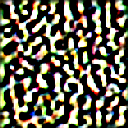

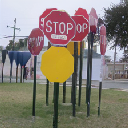

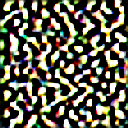

  3%|███████████████████████████▏                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    | 4/120 [16:56<8:10:32, 253.73s/it, test/blurry_cossim=0, test/loss=202, test/loss_blurry_total=0, test/loss_clip_total=0, test/num_steps=4, test/test_bwd_pct_correct=0, test/test

---


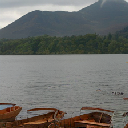

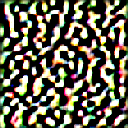

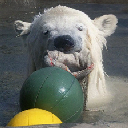

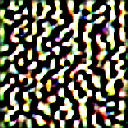

  4%|██████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              | 5/120 [21:09<8:06:08, 253.64s/it, test/blurry_cossim=0, test/loss=432, test/loss_blurry_total=0, test/loss_clip_total=0, test/num_steps=5, test/test_bwd_pct_correct=0, test/test

---


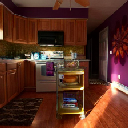

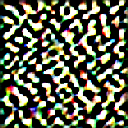

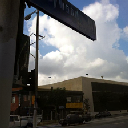

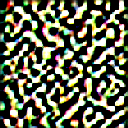

  4%|█████████████████████████████████▉                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           | 5/120 [25:22<8:06:08, 253.64s/it, test/blurry_cossim=0, test/loss=762, test/loss_blurry_total=0, test/loss_clip_total=0, test/num_steps=6, test/test_bwd_pct_correct=0, test/test_fw

---


  5%|████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    | 6/120 [25:45<8:09:21, 257.55s/it, test/blurry_cossim=0, test/loss=762, test/loss_blurry_total=0, test/loss_clip_total=0, test/num_steps=6, test/test_bwd_pct_correct=0, test/test_fw

KeyboardInterrupt: 

In [22]:
print(f"{model_name} starting with epoch {epoch} / {num_epochs}")
progress_bar = tqdm(range(epoch,num_epochs), ncols=1200, disable=(local_rank!=0))
test_image, test_voxel = None, None
mse = nn.MSELoss()
for epoch in progress_bar:
    model.train()
    
    fwd_percent_correct = 0.
    bwd_percent_correct = 0.
    test_fwd_percent_correct = 0.
    test_bwd_percent_correct = 0.

    loss_clip_total = 0.
    loss_blurry_total = 0.
    test_loss_clip_total = 0.
    test_loss_blurry_total = 0.

    blurry_cossim = 0.
    test_blurry_cossim = 0.

    # noise_scheduler = DDIMScheduler(num_train_timesteps=timesteps, rescale_betas_zero_snr=True, timestep_spacing="trailing")#, prediction_type="sample")
    for train_i, (behav, past_behav, future_behav, old_behav) in enumerate(train_dl):
        with torch.cuda.amp.autocast():
            optimizer.zero_grad()

            voxel = voxels[behav[:,0,5].cpu().long()].to(device)
            
            image = images[behav[:,0,0].cpu().long()].to(device).float()

            # get VAE latents from image (vae_scaling makes it so distribution is roughly normal, so works with torch.randn)
            blurry_image_enc = autoenc.encode(image).latent_dist.mode() * vae_scaling
            
            if use_image_aug: image = img_augment(image)
            
            clip_target = clip_model.embed_image(image)
            assert not torch.any(torch.isnan(clip_target))
  
            if epoch < int(mixup_pct * num_epochs):
                voxel, perm, betas, select = utils.mixco(voxel)

            voxel_ridge = model.ridge(voxel)
            
            clip_voxels, blurry_latent = model.backbone(voxel_ridge)
            assert len(blurry_latent) == len(voxel_ridge)

            # diffusion
            noise = torch.randn_like(blurry_image_enc)
            times = torch.randint(0, noise_scheduler.config.num_train_timesteps, (len(voxel),)).long().to(device)

            input = noise_scheduler.add_noise(blurry_image_enc, noise, timesteps=times)
            noise_ = model.diffuser(input, times, blurry_latent).sample
            
            loss = mse(noise, noise_)
            
            utils.check_loss(loss)

            accelerator.backward(loss)
            optimizer.step()
    
            losses.append(loss.item())
            lrs.append(optimizer.param_groups[0]['lr'])
            
            if lr_scheduler_type is not None:
                lr_scheduler.step()

    # use training set for evaluation to sanity test that the model can overfit on training data
    model.eval()
    test_i = 0
    with torch.no_grad(), torch.cuda.amp.autocast():  
        blurry_image_enc_ = sd_sample(len(blurry_latent), model.diffuser, noise_scheduler, blurry_latent, embedding_dim=28)
        loss = mse(blurry_image_enc_, blurry_image_enc)
        test_losses.append(loss.item())

    # model.eval()
    # for test_i, (behav, past_behav, future_behav, old_behav) in enumerate(test_dl):
    #     with torch.no_grad():   
    #         # all test samples should be loaded per batch such that test_i should never exceed 0
    #         if len(behav) != num_test: print("!",len(behav),num_test)
            
    #         ## Average same-image repeats ##
    #         if test_image is None:
    #             voxel = voxels[behav[:,0,5].cpu().long()].to(device)
                
    #             image = behav[:,0,0].cpu().long()
                
    #             unique_image, sort_indices = torch.unique(image, return_inverse=True)
    #             for im in unique_image:
    #                 locs = torch.where(im == image)[0]
    #                 if test_image is None:
    #                     test_image = images[im][None]
    #                     test_voxel = torch.mean(voxel[locs],axis=0)[None]
    #                 else:
    #                     test_image = torch.vstack((test_image, images[im][None]))
    #                     test_voxel = torch.vstack((test_voxel, torch.mean(voxel[locs],axis=0)[None]))

    #         # random sample of batch_size
    #         random_indices = torch.arange(len(test_voxel))[:batch_size] #torch.randperm(len(test_voxel))[:300]
    #         voxel = test_voxel[random_indices].to(device)
    #         image = test_image[random_indices].to(device)
    #         assert len(image) == batch_size

    #         # image = utils.resize(image,256)  

    #         blurry_image_enc = autoenc.encode(image).latent_dist.mode() * vae_scaling
    
    #         clip_target = clip_model.embed_image(image.float())

    #         voxel_ridge = model.ridge(voxel)
            
    #         clip_voxels, blurry_latent = model.backbone(voxel_ridge)
            
    #         # diffusion
    #         blurry_image_enc_ = sd_sample(len(blurry_latent), model.diffuser, noise_scheduler, blurry_latent, embedding_dim=28)
            
    #         loss = mse(blurry_image_enc_, blurry_image_enc)
    #         utils.check_loss(loss)
    
    #         test_losses.append(loss.item())
    
    with torch.no_grad():
        with torch.cuda.amp.autocast():   
            for ii in [0,1]:
                reconst = decode_autoenc(blurry_image_enc[[ii]])
                display(utils.torch_to_Image(utils.resize(reconst)))
        
                reconst_ = decode_autoenc(blurry_image_enc_[[ii]])
                display(utils.torch_to_Image(utils.resize(reconst_)))

    if local_rank==0:      
        if utils.is_interactive():
            # clear_output(wait=True)
            print("---")

        assert (test_i+1) == 1
        logs = {"train/loss": np.mean(losses[-(train_i+1):]),
            "test/loss": np.mean(test_losses[-(test_i+1):]),
            "train/lr": lrs[-1],
            "train/num_steps": len(losses),
            "test/num_steps": len(test_losses),
            "train/fwd_pct_correct": fwd_percent_correct / (train_i + 1),
            "train/bwd_pct_correct": bwd_percent_correct / (train_i + 1),
            "test/test_fwd_pct_correct": test_fwd_percent_correct / (test_i + 1),
            "test/test_bwd_pct_correct": test_bwd_percent_correct / (test_i + 1),
            "train/loss_clip_total": loss_clip_total / (train_i + 1),
            "train/loss_blurry_total": loss_blurry_total / (train_i + 1),
            "test/loss_clip_total": test_loss_clip_total / (test_i + 1),
            "test/loss_blurry_total": test_loss_blurry_total / (test_i + 1),
            "train/blurry_cossim": blurry_cossim / (train_i + 1),
            "test/blurry_cossim": test_blurry_cossim / (test_i + 1),
            }
        progress_bar.set_postfix(**logs)

        # Save model checkpoint and reconstruct
        if epoch % ckpt_interval == 0:
            if not utils.is_interactive():
                save_ckpt(f'last')
                
        if wandb_log: wandb.log(logs)

    # wait for other GPUs to catch up if needed
    accelerator.wait_for_everyone()
    torch.cuda.empty_cache()
    gc.collect()

print("\n===Finished!===\n")
# if ckpt_saving:
#     save_ckpt(f'last')
if not utils.is_interactive():
    sys.exit(0)

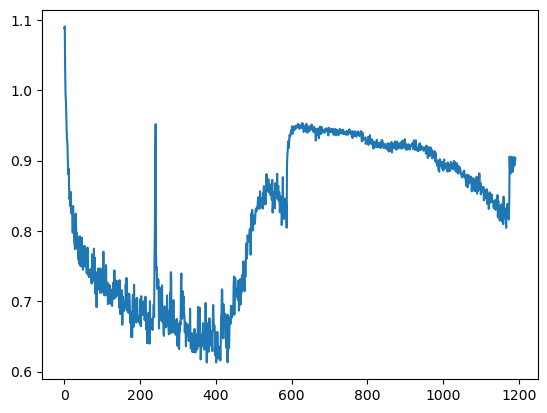

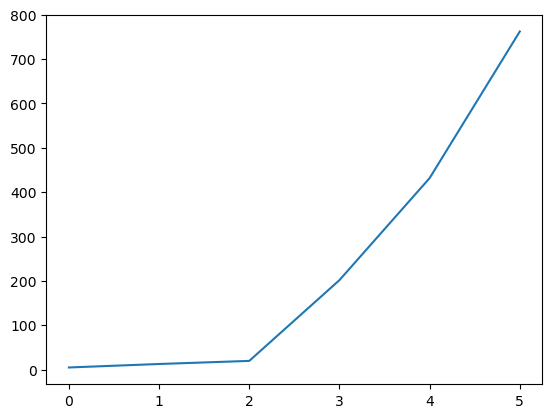

In [23]:
plt.plot(losses);
plt.show()
plt.plot(test_losses)